# Defining a baseline model 

### Objective
To define a baseline model, which is a simple and often minimalist machine learning model that serves as a starting point for solving a particular task. The baseline model will provide a reference point to evaluate the performance of more complex models.


### Baseline Models

To establish a benchmark for evaluating the performance of more complex models, I will implement three simple baseline models:

* **Random Model**: This model randomly classifies each pixel into the positive or negative class based on the overall class distribution in the dataset. While simplistic, it serves as a lower bound for performance and helps ensure that more advanced models are better than chance.

* **Threshold Classifier**: This model classifies pixels based on a fixed intensity threshold for the NIR band. Pixels with intensity values below the threshold are classified as positive, while those above are classified as negative.

* **Logistic Regression Model**: A slightly more sophisticated approach, this model uses logistic regression to predict the class of each pixel based on its NIR intensity. By learning a probabilistic decision boundary, it provides a stronger base

-----

### Import Libs

In [206]:
import matplotlib.pyplot as plt
import os
import numpy as np
from glob import glob
import glob
import random
import imageio
import imageio.v2 as imageio  # Explicitly use version 2 API

import torch.nn as nn
import torch

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import jaccard_score
from PIL import Image

import re
import rasterio
from rasterio.enums import Resampling

import time
from datetime import datetime

### CUDA configuration

In [226]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(70*'-')
print("CUDA available:", torch.cuda.is_available())
current_device = torch.cuda.current_device()
print("GPU Model:", torch.cuda.get_device_name(current_device))
print("CUDA Version:", torch.version.cuda)
print(70*'-')

device_properties = torch.cuda.get_device_properties(current_device)
print("\nDevice Properties:")
print("  Name:", device_properties.name)
print("  Total Memory (GB):", device_properties.total_memory / (1024 ** 3))  # Convert bytes to GB
print("  Multiprocessors:", device_properties.multi_processor_count)
print("  Compute Capability:", device_properties.major, ".", device_properties.minor)
print(70*'-')

----------------------------------------------------------------------
CUDA available: True
GPU Model: NVIDIA GeForce GTX 1080 Ti
CUDA Version: 11.8
----------------------------------------------------------------------

Device Properties:
  Name: NVIDIA GeForce GTX 1080 Ti
  Total Memory (GB): 10.999755859375
  Multiprocessors: 28
  Compute Capability: 6 . 1
----------------------------------------------------------------------


# Import Dataset
- Import folder with images
- Import folder with masks
- Create list with training and testing data

In [208]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0
    
# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/test/labels/*tif"),
    key=numeric_sort_key
)

# Assign to variables
train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]


In [209]:
# Check the number of train, val and test images
print('\nControl number of images by folder:')
print(40*'=')
input_total = len(folder_data_train)+len(folder_data_val)+len(folder_data_test)
labels_total = len(folder_mask_train)+len(folder_mask_val)+len(folder_mask_test)
print('\t\tinput: \tlabels:')
print(f'Train\t\t{len(folder_data_train)}\t{len(folder_mask_train)}\t{(len(folder_data_train)/input_total)*100:.2f}%')
print(f'Val\t\t{len(folder_data_val)}\t{len(folder_mask_val)}\t{(len(folder_data_val)/input_total)*100:.2f}%')
print(f'Test\t\t{len(folder_data_test)}\t{len(folder_mask_test)}\t{(len(folder_data_test)/input_total)*100:.2f}%')
print(40*'=')
print(f'Total\t\t{input_total}\t{labels_total}')


Control number of images by folder:
		input: 	labels:
Train		201	201	73.90%
Val		35	35	12.87%
Test		36	36	13.24%
Total		272	272


## Explore the Dataset

In [211]:
def plot_histograms(image_paths, num_samples=5):
    """
    Plot histograms for each band (R, G, B, NIR) for a given sample of images.
    """
    red_values = []
    green_values = []
    blue_values = []
    nir_values = []
    
    # Iterate over a subset of images
    for img_path in image_paths[:num_samples]:  
        image = imageio.imread(img_path)
        
        # Separate the bands
        red_values.extend(image[:, :, 0].flatten())
        green_values.extend(image[:, :, 1].flatten())
        blue_values.extend(image[:, :, 2].flatten())
        nir_values.extend(image[:, :, 3].flatten())

    # Plot histograms
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(red_values, bins=50, color='red', alpha=0.7)
    plt.title("Red Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 2)
    plt.hist(green_values, bins=50, color='green', alpha=0.7)
    plt.title("Green Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 3)
    plt.hist(blue_values, bins=50, color='blue', alpha=0.7)
    plt.title("Blue Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 4)
    plt.hist(nir_values, bins=50, color='purple', alpha=0.7)
    plt.title("NIR Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()



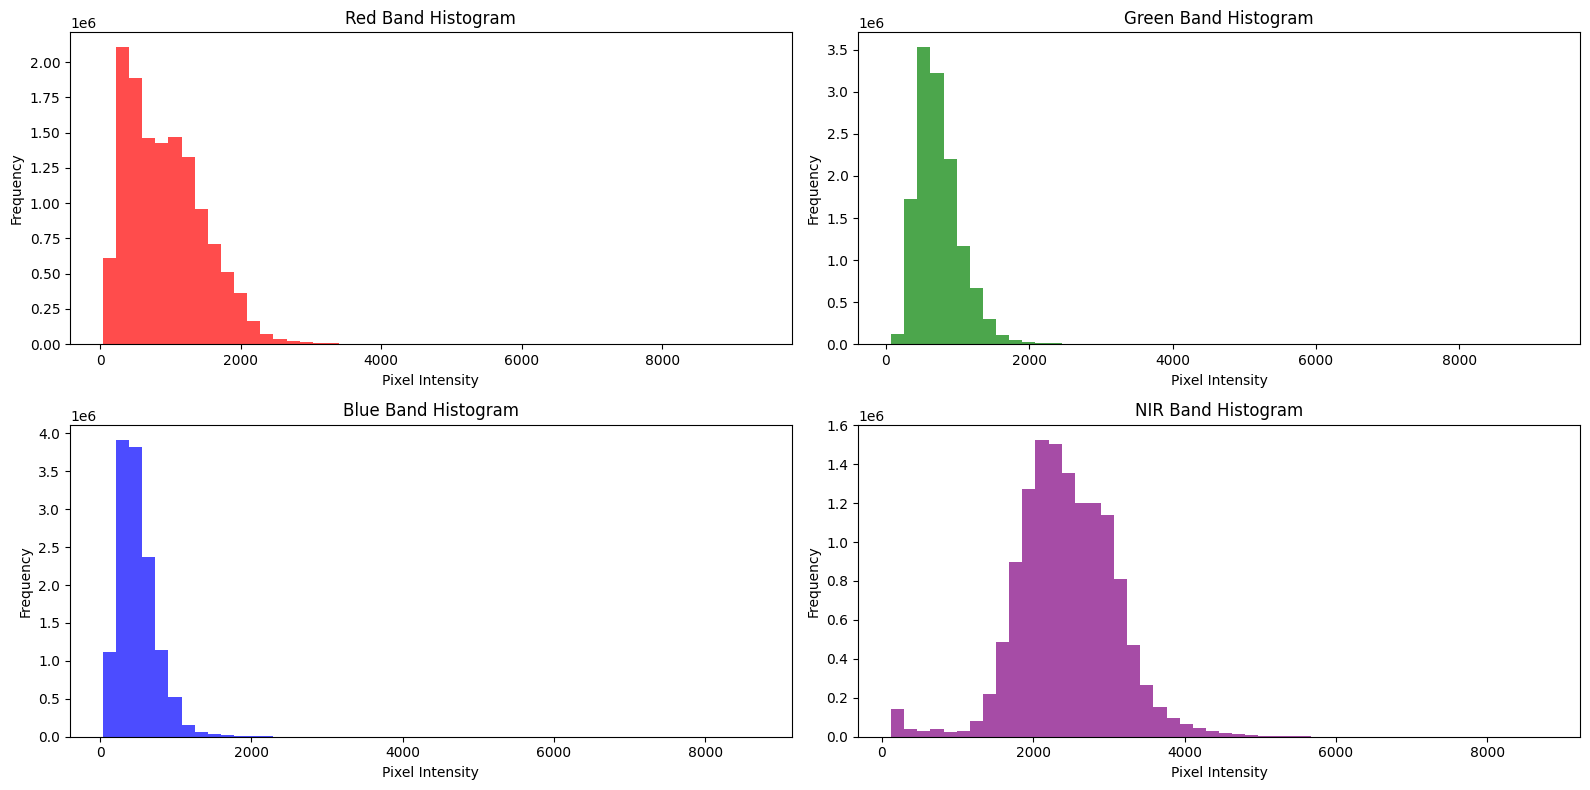

In [212]:
# Call the function with your training image paths
plot_histograms(train_image_paths, num_samples=250)

## Images statistics by band


In [214]:

def central_stats(image_paths):
    # Initialize arrays to accumulate mean, std, min and max values for each band
    mean_values = np.zeros(4)
    std_values = np.zeros(4)
    min_values = np.full(4, np.inf)
    max_values = np.full(4, -np.inf)
    
    n_pixels = 0  # Total pixel count across all images (for averaging)
    
    # Iterate over all images in the training set
    for img_path in image_paths:
        # Load the image and cast to float32 for precision
        image = imageio.imread(img_path).astype(np.float32)
        
        # Calculate the mean and std per band for this image
        mean_per_image = image.mean(axis=(0, 1))  # Mean across spatial dimensions
        std_per_image = image.std(axis=(0, 1))    # Std deviation across spatial dimensions
        
        # Accumulate the total mean and std values
        mean_values += mean_per_image
        std_values += std_per_image
            
        # Calculate and update the min and max per band
        min_per_image = image.min(axis=(0, 1))
        max_per_image = image.max(axis=(0, 1))
        for i in range(len(min_values)):
            min_values[i] = min(min_values[i], min_per_image[i])
            max_values[i] = max(max_values[i], max_per_image[i])
    
    # Average the mean and std across all images
    mean_values /= len(image_paths)
    std_values /= len(image_paths)
    
    print("Mean per band (R, G, B, NIR):", mean_values)
    print("Std deviation per band (R, G, B, NIR):", std_values)
    print("Min values per band (R, G, B, NIR):", min_values)
    print("Max values per band (R, G, B, NIR):", max_values)


In [215]:
central_stats(train_image_paths)

Mean per band (R, G, B, NIR): [ 927.75739512  740.14410416  492.39665161 2441.67961341]
Std deviation per band (R, G, B, NIR): [420.10468167 257.58737858 200.92512581 500.59008288]
Min values per band (R, G, B, NIR): [ 38.  74.  35. 123.]
Max values per band (R, G, B, NIR): [9380. 9224. 8710. 8791.]


------

## 1- Random Model

In [233]:
class RandomModel(nn.Module):
    def __init__(self, positive_prob):
        """
        Random model that generates predictions based on the distribution of positive and negative classes.
        """
        super(RandomModel, self).__init__()
        self.positive_prob = positive_prob

    def forward(self, x):
        """
        Forward pass for the random model.
        It generates random predictions based on the class distribution.
        """
        batch_size, _, height, width = x.size()
        random_probs = torch.rand(batch_size, 1, height, width, device=x.device)
        random_preds = (random_probs < self.positive_prob).float()
        return random_preds

def compute_positive_class_probability(mask_paths):
    """
    Compute the probability of the positive class (1) across all training masks.
    """
    total_pixels = 0
    positive_pixels = 0

    for mask_path in mask_paths:
        mask = imageio.imread(mask_path)
        total_pixels += mask.size
        positive_pixels += np.sum(mask)  # Assuming positive class is represented by 1

    positive_prob = positive_pixels / total_pixels
    return positive_prob

In [235]:
positive_prob = compute_positive_class_probability(train_mask_paths)
print(f"Positive Class Probability: {positive_prob:.4f}")

Positive Class Probability: 0.0230


In [237]:
# Compute the positive class probability from the training masks
positive_prob = compute_positive_class_probability(train_mask_paths)

# Initialize the random model
random_model = RandomModel(positive_prob=positive_prob).to(DEVICE)

# Evaluate the model
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(random_model, test_loader, DEVICE)
print("Random Model Results (with class distribution):")
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)


NameError: name 'compute_confusion_matrix_with_distributions' is not defined

In [146]:
def plot_NIR_hist_per_class(image_paths, mask_paths, num_samples=5):
    """
    Plot histograms for NIR band according with mask's binary classification (1- possitive and 0- background)
    """
    nir_values_positive = []
    nir_values_negative = []
    result = []

    for img_path, mask_path in zip(image_paths[:num_samples], mask_paths[:num_samples]):
        image = imageio.imread(img_path)
        mask = imageio.imread(mask_path)

        # define the two arrays
        nir_values = image[:, :, 3].flatten()
        mask_values = mask[:,:].flatten()

        # multiply element-wise the image array with the mask array. 
        # Then, the result are the reflectance pixel value for the NIR band where the mask is positive (1)
        nir_values_positive.extend(nir_values * mask_values)
        nir_values_negative.extend(nir_values * (1 - mask_values))

    # drop the zero values
    # (consider that the minimum values for the NIR band images across the entire dataset are greater than zero)
    nir_values_positive = np.array([nir_values_positive])
    nir_values_negative = np.array([nir_values_negative])
    positives_nonzero = nir_values_positive[nir_values_positive != 0 ]
    negatives_nonzero = nir_values_negative[nir_values_negative != 0 ]
    
    plt.figure(figsize=(8, 6))
    
    plt.hist(positives_nonzero, bins=200, color='red', alpha=0.7, label="Positive class NIR pixels distribution")
    plt.hist(negatives_nonzero, bins=200, color='grey', alpha=0.7, label="Negative class NIR pixels distribution")
    plt.title("NIR Band Pixel Distribution for Positive and Negative Mask Classes")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    nb_pixels = positives_nonzero.shape[0] + negatives_nonzero.shape[0]
    nb_images = nb_pixels / (image.shape[0] * image.shape[1])
    return print(f"{nb_pixels:,} pixels considered from {int(nb_images)} images ")    
        
        
    

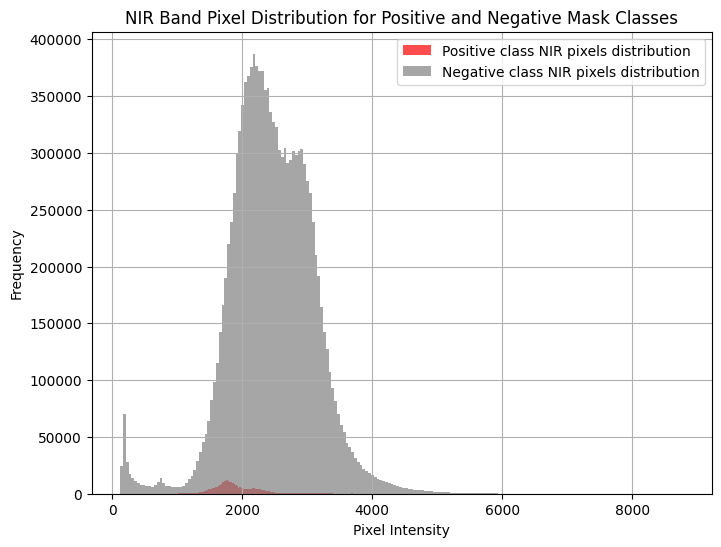

13,172,736 pixels considered from 201 images 


In [148]:
plot_NIR_hist_per_class(train_image_paths, train_mask_paths, num_samples=250)

In [108]:
13172736/(256*256)

201.0

# CUDA configuration

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(70*'-')
print("CUDA available:", torch.cuda.is_available())
current_device = torch.cuda.current_device()
print("GPU Model:", torch.cuda.get_device_name(current_device))
print("CUDA Version:", torch.version.cuda)
print(70*'-')

device_properties = torch.cuda.get_device_properties(current_device)
print("\nDevice Properties:")
print("  Name:", device_properties.name)
print("  Total Memory (GB):", device_properties.total_memory / (1024 ** 3))  # Convert bytes to GB
print("  Multiprocessors:", device_properties.multi_processor_count)
print("  Compute Capability:", device_properties.major, ".", device_properties.minor)
print(70*'-')

----------------------------------------------------------------------
CUDA available: True
GPU Model: NVIDIA GeForce GTX 1080 Ti
CUDA Version: 11.8
----------------------------------------------------------------------

Device Properties:
  Name: NVIDIA GeForce GTX 1080 Ti
  Total Memory (GB): 10.999755859375
  Multiprocessors: 28
  Compute Capability: 6 . 1
----------------------------------------------------------------------


### Before importing the dataset, apply Super Resolution to the source images 

In [8]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0
    
def preprocess_dataset(image_dir, mask_dir, output_dir, scale_factor=2):
    """
    Preprocess the dataset by applying super-resolution and saving the results using rasterio.
    
    Args:
        image_dir (str): Directory containing input images.
        mask_dir (str): Directory containing mask images.
        output_dir (str): Base directory to store the preprocessed data.
        scale_factor (int): Factor by which to upscale the images.
    """
    # Get all the image and mask paths and sort them numerically
    image_paths = sorted(glob.glob(f"{image_dir}/*.tif"), key=numeric_sort_key)
    mask_paths = sorted(glob.glob(f"{mask_dir}/*.tif"), key=numeric_sort_key)

    # Create output directories for images and masks
    images_output_dir = Path(output_dir) / "input"
    masks_output_dir = Path(output_dir) / "labels"
    images_output_dir.mkdir(parents=True, exist_ok=True)
    masks_output_dir.mkdir(parents=True, exist_ok=True)

    # Process images
    print(f"Processing {len(image_paths)} images...")
    for img_path in image_paths:
        with rasterio.open(img_path) as src:
            # Read and upscale each band
            upscaled_data = []
            for band in range(1, src.count + 1):  # Loop through bands
                band_data = src.read(band)
                upscaled_band = zoom(band_data, scale_factor, order=3)  # Cubic interpolation
                upscaled_data.append(upscaled_band)
            
            # Write to a new file
            meta = src.meta.copy()
            meta.update({
                "height": int(src.height * scale_factor),
                "width": int(src.width * scale_factor),
                "transform": src.transform * rasterio.Affine.scale(1 / scale_factor),
            })
            output_path = images_output_dir / os.path.basename(img_path)
            with rasterio.open(output_path, "w", **meta) as dst:
                for i, band_data in enumerate(upscaled_data, start=1):
                    dst.write(band_data, i)
    
    # Process masks
    print(f"Processing {len(mask_paths)} masks...")
    for mask_path in mask_paths:
        with rasterio.open(mask_path) as src:
            mask_data = src.read(1)  # Single-band mask
            upscaled_mask = zoom(mask_data, scale_factor, order=0)  # Nearest-neighbor interpolation
            
            # Write to a new file
            meta = src.meta.copy()
            meta.update({
                "height": int(src.height * scale_factor),
                "width": int(src.width * scale_factor),
                "transform": src.transform * rasterio.Affine.scale(1 / scale_factor),
            })
            output_path = masks_output_dir / os.path.basename(mask_path)
            with rasterio.open(output_path, "w", **meta) as dst:
                dst.write(upscaled_mask, 1)

    print(f"Preprocessing complete. Data saved to: {output_dir}")


In [10]:
# preprocess_dataset(
#     image_dir = '../5-Data_Wrangling/data_split2/train/input/', 
#     mask_dir = '../5-Data_Wrangling/data_split2/train/labels/',
#     output_dir = '../5-Data_Wrangling/data_split2sr/train/',
#     scale_factor=2
# )

In [12]:
# preprocess_dataset(
#     image_dir = '../5-Data_Wrangling/data_split2/val/input/', 
#     mask_dir = '../5-Data_Wrangling/data_split2/val/labels/',
#     output_dir = '../5-Data_Wrangling/data_split2sr/val/',
#     scale_factor=2
# )

In [14]:
# preprocess_dataset(
#     image_dir = '../5-Data_Wrangling/data_split2/test/input/', 
#     mask_dir = '../5-Data_Wrangling/data_split2/test/labels/',
#     output_dir = '../5-Data_Wrangling/data_split2sr/test/',
#     scale_factor=2
# )

# Import Dataset
- Import folder with images
- Import folder with masks
- Create list with training and testing data

In [17]:

# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/test/labels/*tif"),
    key=numeric_sort_key
)

# # Assign to variables
# train_image_paths = folder_data_train[:]
# val_image_paths = folder_data_val[:]
# test_image_paths = folder_data_test[:]

# train_mask_paths = folder_mask_train[:]
# val_mask_paths = folder_mask_val[:]
# test_mask_paths = folder_mask_test[:]

# debugging
train_image_paths = folder_data_train[:100]
val_image_paths = folder_data_val[:12]
test_image_paths = folder_data_test[:12]

train_mask_paths = folder_mask_train[:100]
val_mask_paths = folder_mask_val[:12]
test_mask_paths = folder_mask_test[:12]


In [19]:
# Check the number of train, val and test images
print('\nControl number of images by folder:')
print(40*'=')
input_total = len(folder_data_train)+len(folder_data_val)+len(folder_data_test)
labels_total = len(folder_mask_train)+len(folder_mask_val)+len(folder_mask_test)
print('\t\tinput: \tlabels:')
print(f'Train\t\t{len(folder_data_train)}\t{len(folder_mask_train)}\t{(len(folder_data_train)/input_total)*100:.2f}%')
print(f'Val\t\t{len(folder_data_val)}\t{len(folder_mask_val)}\t{(len(folder_data_val)/input_total)*100:.2f}%')
print(f'Test\t\t{len(folder_data_test)}\t{len(folder_mask_test)}\t{(len(folder_data_test)/input_total)*100:.2f}%')
print(40*'=')
print(f'Total\t\t{input_total}\t{labels_total}')


Control number of images by folder:
		input: 	labels:
Train		201	201	73.90%
Val		35	35	12.87%
Test		36	36	13.24%
Total		272	272


In [21]:
def plot_histograms(image_paths, num_samples=5):
    """
    Plot histograms for each band (R, G, B, NIR) for a given sample of images.
    """
    red_values = []
    green_values = []
    blue_values = []
    nir_values = []
    
    # Iterate over a subset of images
    for img_path in image_paths[:num_samples]:  
        image = imageio.imread(img_path)
        
        # Separate the bands
        red_values.extend(image[:, :, 0].flatten())
        green_values.extend(image[:, :, 1].flatten())
        blue_values.extend(image[:, :, 2].flatten())
        nir_values.extend(image[:, :, 3].flatten())
    
    # Plot histograms
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(red_values, bins=50, color='red', alpha=0.7)
    plt.title("Red Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 2)
    plt.hist(green_values, bins=50, color='green', alpha=0.7)
    plt.title("Green Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 3)
    plt.hist(blue_values, bins=50, color='blue', alpha=0.7)
    plt.title("Blue Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 4)
    plt.hist(nir_values, bins=50, color='purple', alpha=0.7)
    plt.title("NIR Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Call the function with your training image paths
#plot_histograms(train_image_paths, num_samples=100)

In [77]:
def calculate_class_balance_from_paths(mask_paths):
    """
    Calculate the class balance (proportion of positive and negative pixels) for a dataset using mask file paths.
    Args:
        mask_paths: List of file paths to mask images.
    Returns:
        class_balance: Dictionary with the proportion of positive and negative pixels.
    """
    total_pixels = 0
    positive_pixels = 0

    for mask_path in mask_paths:
        mask = imageio.imread(mask_path).astype(np.float32)
        mask = np.where(mask > 0.5, 1, 0)
        
        total_pixels += mask.size
        positive_pixels += mask.sum()

    negative_pixels = total_pixels - positive_pixels

    # Calculate proportions
    positive_ratio = positive_pixels / total_pixels
    negative_ratio = negative_pixels / total_pixels

    class_balance = {
        "positive_ratio": positive_ratio,
        "negative_ratio": negative_ratio,
        "total_pixels": total_pixels,
    }

    return class_balance

    

In [25]:
# Calculate the training, validation, and test sets class balance
train_balance = calculate_class_balance_from_paths(train_mask_paths)
val_balance = calculate_class_balance_from_paths(val_mask_paths)
test_balance = calculate_class_balance_from_paths(test_mask_paths)

print("Class Balance in Training Set:", train_balance)
print("Class Balance in Validation Set:", val_balance)
print("Class Balance in Test Set:", test_balance)

Class Balance in Training Set: {'positive_ratio': 0.041524200439453124, 'negative_ratio': 0.9584757995605468, 'total_pixels': 26214400}
Class Balance in Validation Set: {'positive_ratio': 0.045077006022135414, 'negative_ratio': 0.9549229939778646, 'total_pixels': 3145728}
Class Balance in Test Set: {'positive_ratio': 0.1297022501627604, 'negative_ratio': 0.8702977498372396, 'total_pixels': 3145728}


## Normalization: Calculate Mean and StdDev from the training set (consider the 4-bands)


In [28]:
# For Image's normalization: Calculate Mean and Standard Deviation for all the training set

train_image_paths = glob.glob("../5-Data_Wrangling/data_split2sr/train/input/*.tif")

# Initialize arrays to accumulate mean and std values for each band
mean_values = np.zeros(4)
std_values = np.zeros(4)
n_pixels = 0  # Total pixel count across all images (for averaging)

# Iterate over all images in the training set
for img_path in train_image_paths:
    # Load the image and cast to float32 for precision
    image = imageio.imread(img_path).astype(np.float32)
    
    # Calculate the mean and std per band for this image
    mean_per_image = image.mean(axis=(0, 1))  # Mean across spatial dimensions
    std_per_image = image.std(axis=(0, 1))    # Std deviation across spatial dimensions
    
    # Accumulate the total mean and std values
    mean_values += mean_per_image
    std_values += std_per_image
    n_pixels += image.shape[0] * image.shape[1]  # Accumulate pixel count for averaging

# Average the mean and std across all images
mean_values /= len(train_image_paths)
std_values /= len(train_image_paths)

print("Mean per band (R, G, B, NIR):", mean_values)
print("Std deviation per band (R, G, B, NIR):", std_values)


Mean per band (R, G, B, NIR): [ 927.72309094  740.12511994  492.37997292 2441.66539495]
Std deviation per band (R, G, B, NIR): [419.47567552 257.08428302 200.48893916 499.48728449]


## Super Resolution using CV2

In [30]:
# def apply_super_resolution_opencv(image, scale_factor=2, interpolation=cv2.INTER_CUBIC):
#     """
#     Apply OpenCV interpolation to enhance image resolution.
#     Args:
#         image (numpy array): Input image as a numpy array.
#         scale_factor (int): Factor by which to upscale the image.
#         interpolation: Interpolation method (default is cv2.INTER_CUBIC).
#     Returns:
#         numpy array: Upscaled image.
#     """
#     height, width = image.shape[:2]
#     new_dimensions = (width * scale_factor, height * scale_factor)
#     upscaled_image = cv2.resize(image, new_dimensions, interpolation=interpolation)
#     return upscaled_image


# Custom Dataset

In [32]:
class CustomDataset(data.Dataset):
    def __init__(self, image_paths, target_paths, transform=None, band=None, device='cuda'):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform
        self.band = band # Specify which band to use (0: R, 1: G, 2: B, 3: NIR, None: all bands)
        self.scaler = MinMaxScaler()
        self.device = device  # Specify the device for preloading

        # Preload images and masks into GPU memory
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Preloading images and masks into GPU memory...")
        # self.images = [torch.tensor(cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32), device=self.device) for path in image_paths]
        # self.masks = [torch.tensor(cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32), device=self.device) for path in target_paths]
        self.images = image_paths
        self.masks = target_paths
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Preloading complete.")

        
                
    def __getitem__(self, index):
        # Debugging: Print dataset lengths and current index
        print(f"[DEBUG] Dataset size: {len(self.image_paths)} images, {len(self.masks)} masks")
        print(f"[DEBUG] Current index: {index}")
    
        # Access the paths safely
        try:
            # Get the current timestamp
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            
             # Log the index being loaded
            print(f"[{timestamp}] Loading image and mask for index {index}...")
            
            # Retrieve preloaded image and mask
            # image = self.images[index]
            # mask = self.masks[index]
             # Debugging: Add print statements for image and mask paths
            print(f"Loading image: {self.image_paths[index]}")
            print(f"Loading mask: {self.masks[index]}")
            image = torch.tensor(cv2.imread(self.images[index], cv2.IMREAD_UNCHANGED).astype(np.float32))
            mask = torch.tensor(cv2.imread(self.masks[index], cv2.IMREAD_UNCHANGED).astype(np.float32))
            print(f"Image shape: {image.shape}, dtype: {image.dtype}")
            print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
               
            # Select a specific band if specified
            if self.band is not None:
                image = image[:, :, self.band].unsqueeze(2)  # Add channel dimension

                
            # Normalize the image
            # image_reshaped = image.reshape(-1, image.shape[-1])
            # image_scaled = self.scaler.fit_transform(image_reshaped)
            # image = image_scaled.reshape(image.shape)

             # Normalize the image (Min-Max normalization)
            image_min = image.min()
            image_max = image.max()
            if image_max > image_min:  # Avoid division by zero
                image = (image - image_min) / (image_max - image_min)

            # Reshape for MinMaxScaler and apply normalization
            #image_reshaped = image.reshape(-1, 4)
            #image_scaled = self.scaler.fit_transform(image_reshaped)
            #image = image_scaled.reshape(image.shape)
            
            # Load the 1-band binary mask
            # mask = imageio.imread(self.target_paths[index])
            # mask = np.asarray(mask, dtype='float32')
            #mask = np.where(mask>1, 0, mask) # some images has soil annotations as well
            mask = torch.where(mask > 1, torch.tensor(0.0, device=self.device), mask)
    
            # Debugging: Print shapes and types
            #print(f"Image shape: {image.shape}, dtype: {image.dtype}")
            #print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")

            # Debugging: Log the properties of the loaded image and mask
            print(f"[{timestamp}] Image shape: {image.shape}, dtype: {image.dtype}")
            print(f"[{timestamp}] Mask shape: {mask.shape}, dtype: {mask.dtype}")

    
            # Apply the transformation to both image and mask if self.transform is set
            if self.transform:
                try:
                    image, mask = self.transform(image, mask)  # Pass both to transform if synchronized
                except Exception as e:
                    print(f"[{timestamp}] Error during transformation at index {index}: {e}")
                    raise e
    
            return image, mask
        
        except Exception as e:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Error at index {index}: {e}")
            raise e

    def __len__(self):

        return len(self.image_paths)



# class CustomDataset(data.Dataset):
#     def __init__(self, image_paths, target_paths, transform=None, band=None, apply_super_resolution=False, scale_factor=2):

#         self.image_paths = image_paths
#         self.target_paths = target_paths
#         self.transform = transform
#         self.band = band # Specify which band to use (0: R, 1: G, 2: B, 3: NIR, None: all bands)
#         self.scaler = MinMaxScaler()
#         self.apply_super_resolution = apply_super_resolution
#         self.scale_factor = scale_factor  # Scaling factor for super-resolution
#         #self.sr_model = sr_model
#         #self.res_printed = False
                
#     def __getitem__(self, index):
        
#         image = imageio.imread(self.image_paths[index]).astype(np.float32)

#         # Select a specific band if specified
#         if self.band is not None:
#             image = image[:, :, self.band] #Select only the specified band
#             image = image[:, :, np.newaxis]
            
#         # Load the 1-band binary mask
#         mask = imageio.imread(self.target_paths[index])
#         mask = np.asarray(mask, dtype='float32')
#         mask = np.where(mask>1, 0, mask) # some images has soil annotations as well

#         # Apply super-resolution if enabled
#         if self.apply_super_resolution:
#             image = apply_super_resolution_opencv(image, scale_factor=self.scale_factor, interpolation=cv2.INTER_CUBIC)
#             mask = apply_super_resolution_opencv(mask, scale_factor=self.scale_factor, interpolation=cv2.INTER_NEAREST)  # Use INTER_NEAREST for masks
    
#         # Normalize the image
#         image_reshaped = image.reshape(-1, image.shape[-1])
#         image_scaled = self.scaler.fit_transform(image_reshaped)
#         image = image_scaled.reshape(image.shape)

#         # # Convert to PyTorch tensor
#         # image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(DEVICE)  # Add batch dimension

#         # # Apply super-resolution if enabled
#         # if self.apply_super_resolution and self.sr_model:
#         #     with torch.no_grad():
#         #         image_tensor = self.sr_model(image_tensor).squeeze(0)  # Remove batch dimension
#         #         if not self.res_printed:
#         #             print(f'image resolution after super res: {image_tensor.shape}')
#         #             self.res_printed = True
                            
        
#         # Debugging: Print shapes and types
#         #print(f"Image shape: {image.shape}, dtype: {image.dtype}")
#         #print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")

#         # Apply the transformation to both image and mask if self.transform is set
#         if self.transform:
#             image, mask = self.transform(image, mask)  # Pass both to transform if synchronized

#         return image, mask


#     def __len__(self):

#         return len(self.image_paths)





## Adding Data Augmentation

In [34]:
class SynchronizedTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        # Convert tensors to NumPy arrays if needed
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        
        # Convert numpy arrays to PIL images
        if image.ndim == 3 and image.shape[-1] == 1:  # Single-band images
            image = image.squeeze(-1)  # Remove the singleton channel
        image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255
        mask = Image.fromarray((mask * 255).astype(np.uint8))

        for transform in self.transforms:
            if isinstance(transform, transforms.RandomHorizontalFlip):
                if torch.rand(1).item() < 0.5:
                    image = TF.hflip(image)
                    mask = TF.hflip(mask)
            elif isinstance(transform, transforms.RandomVerticalFlip):
                if torch.rand(1).item() < 0.5:
                    image = TF.vflip(image)
                    mask = TF.vflip(mask)
            elif isinstance(transform, transforms.RandomChoice):
                angle = random.choice([0, 90, 180, 270])
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            elif isinstance(transform, transforms.ToTensor):
                image = TF.to_tensor(image)
                mask = TF.to_tensor(mask)

        return image, mask


# class SynchronizedTransform:
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, mask):
#         # Convert tensors to NumPy arrays if needed
#         if isinstance(image, torch.Tensor):
#             image = image.numpy()  # Convert tensor to NumPy array
#         if isinstance(mask, torch.Tensor):
#             mask = mask.numpy()  # Convert tensor to NumPy array
        
        
#         # Convert numpy arrays to PIL images
#         #image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255 for display

#         # Convert numpy arrays to PIL images
#         if image.ndim == 3 and image.shape[-1] == 1:  # Single-band images
#             image = image.squeeze(-1)  # Remove the singleton channel

#         # Conver to PIL images
#         image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255
#         mask = Image.fromarray((mask * 255).astype(np.uint8))

        
#         for transform in self.transforms:
#             if isinstance(transform, transforms.RandomHorizontalFlip):
#                 if torch.rand(1).item() < 0.5:
#                     image = TF.hflip(image)
#                     mask = TF.hflip(mask)
#             elif isinstance(transform, transforms.RandomVerticalFlip):
#                 if torch.rand(1).item() < 0.5:
#                     image = TF.vflip(image)
#                     mask = TF.vflip(mask)
#             elif isinstance(transform, transforms.RandomChoice):
#                 # Pick a random rotation angle from the specified options
#                 angle = random.choice([0, 90, 180, 270])
#                 image = TF.rotate(image, angle)
#                 mask = TF.rotate(mask, angle)
#             elif isinstance(transform, transforms.ToTensor):
#                 image = TF.to_tensor(image)
#                 mask = TF.to_tensor(mask)

#         return image, mask
        


In [39]:
simple_transform = SynchronizedTransform([
    transforms.ToTensor()  # Convert both image and mask to tensor
])

# augmentation_transform = SynchronizedTransform([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomChoice([
#         transforms.RandomRotation(0),
#         transforms.RandomRotation(90),
#         transforms.RandomRotation(180),
#         transforms.RandomRotation(270)
#     ]),
#     transforms.ToTensor()
# ])


augmentation_transform = SynchronizedTransform([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomChoice([
    #     transforms.RandomRotation(0),
    #     transforms.RandomRotation(90),
    #     transforms.RandomRotation(180),
    #     transforms.RandomRotation(270)
    # ]),
    transforms.ToTensor()
])

# Load a pre-trained super-resolution model (e.g., SRResNet)
# sr_model = super_resolution.srresnet_1x().to(DEVICE)
# sr_model.eval()

use_all_bands = False
model_band = 3 # 0:red, 1:green, 2:blue, 3:NIR, None:all 4 bands

train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)

# train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
# val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
# test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)

# image, mask = train_dataset[0]  # Load the first item
# print(f"Transformed image shape: {image.shape}, dtype: {image.dtype}")
# print(f"Transformed mask shape: {mask.shape}, dtype: {mask.dtype}")

# train_dataset = CustomDataset(
#     train_image_paths, 
#     train_mask_paths, 
#     transform=augmentation_transform, 
#     band=model_band, 
#     apply_super_resolution = True,
#     scale_factor = 2)

# val_dataset = CustomDataset(
#     val_image_paths, 
#     val_mask_paths, 
#     transform=simple_transform, 
#     band=model_band, 
#     apply_super_resolution = True,
#     scale_factor = 2)

# test_dataset = CustomDataset(
#     test_image_paths, 
#     test_mask_paths, 
#     transform=simple_transform, 
#     band=model_band, 
#     apply_super_resolution = True,
#     scale_factor = 2)

# image, mask = train_dataset[0]  # Load the first item
# print(f"Transformed image shape: {image.shape}, dtype: {image.dtype}")
# print(f"Transformed mask shape: {mask.shape}, dtype: {mask.dtype}")

[2024-12-08 15:00:46] Preloading images and masks into GPU memory...
[2024-12-08 15:00:46] Preloading complete.
[2024-12-08 15:00:46] Preloading images and masks into GPU memory...
[2024-12-08 15:00:46] Preloading complete.
[2024-12-08 15:00:46] Preloading images and masks into GPU memory...
[2024-12-08 15:00:46] Preloading complete.


### Control the synchronization of Data Augmentation transforms 

In [42]:
def visualize_augmentations(dataset, num_samples=3):
    for i in range(num_samples):
        image, mask = dataset[i]
        
        # Display input image and mask side-by-side
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for display
        plt.title("Augmented Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask[0], cmap='gray')  # Show mask in grayscale
        plt.title("Augmented Mask")
        
        plt.show()

In [44]:
visualize_augmentations(train_dataset, num_samples=15)

[2024-12-08 15:00:48] Loading image and mask for index 0...
Loading image: ../5-Data_Wrangling/data_split2sr/train/input\img(100).tif
Loading mask: ../5-Data_Wrangling/data_split2sr/train/labels\target(100).tif
Image shape: torch.Size([512, 512, 4]), dtype: torch.float32
Mask shape: torch.Size([512, 512]), dtype: torch.float32
[2024-12-08 15:00:48] Error at index 0: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [46]:
train_dataset.image_paths[:20], train_dataset.target_paths[:20]

(['../5-Data_Wrangling/data_split2sr/train/input\\img(100).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1001).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1002).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1003).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1004).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1005).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1006).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1007).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1008).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1009).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(101).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1010).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1011).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1012).tif',
  '../5-Data_Wrangling/data_split2sr/train/input\\img(1013).tif',
  '../5-Data

In [48]:
image_datasets = {
    'train': train_dataset, 'val': val_dataset, 'test': test_dataset
}

#dataloaders = {
#    'train': torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0),
#    'val': torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=0),
#    'test': torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=0)
#}

# Import Model

In [51]:
ENCODER = 'efficientnet-b7'
#ENCODER = 'efficientnet-b0' #for DeepLabV3+
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#model = smp.Unet(
#model = smp.DeepLabV3Plus(
model = smp.UnetPlusPlus(
    in_channels = 4 if use_all_bands else 1, #4 for all bands
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    #decoder_atrous_rates = (6, 12, 24) # for DeepLabv3+
    #decoder_dropout=0.3
       
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


# Loss & Optimizer

In [54]:

class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0, neg_weight=1.0):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight  # Weight for positive class
        self.neg_weight = neg_weight  # Weight for negative class

    def forward(self, inputs, targets):
        # print(f"weights: pos {self.pos_weight} neg {self.neg_weight}") # debugging
        # Weighted BCE computation
        loss = -self.pos_weight * targets * torch.log(inputs + 1e-7) - \
               self.neg_weight * (1 - targets) * torch.log(1 - inputs + 1e-7)
        return loss.mean()

class BCEFocalNegativeIoULoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=1.5, pos_weight=2.0, neg_weight=1.0):
        """
        Args:
            alpha: Weight for Focal Loss.
            gamma: Modulating factor for Focal Loss.
            pos_weight: Weight for positive class in BCE Loss.
            neg_weight: Weight for negative class in BCE Loss.
        """
        super(BCEFocalNegativeIoULoss, self).__init__()
        self.bce = WeightedBCELoss(pos_weight=pos_weight, neg_weight=neg_weight)
        self.alpha = alpha
        self.gamma = gamma

    def focal_loss(self, inputs, targets):
        BCE_loss = -targets * torch.log(inputs + 1e-7) - (1 - targets) * torch.log(1 - inputs + 1e-7)
        #pt = torch.exp(-BCE_loss)  # Probability of the true class
        pt = inputs * targets + (1 - inputs) * (1 - targets)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

    def forward(self, inputs, targets):
        if targets.sum() == 0:  # Skip blank masks
            return torch.tensor(0.0, requires_grad=True).to(inputs.device)

        # Core loss components
        bce_loss = self.bce(inputs, targets)
        focal_loss = self.focal_loss(inputs, targets)

        # Compute IoU for positive and negative classes
        #preds = inputs.sigmoid()  # Apply sigmoid activation
        preds = inputs
        #preds = model(inputs)  # No need to apply sigmoid again if already applied in the model
        iou_positive, mean_iou = compute_class_aware_iou(preds, targets)

        # Jaccard Loss for Positive and Negative IoU
        jaccard_loss_positive = 1.0 - iou_positive  # Positive IoU
        jaccard_loss_negative = 1.0 - (2 * mean_iou - iou_positive)  # Derive Negative IoU

        # Weighted Jaccard Loss
        jaccard_loss = 0.85 * jaccard_loss_positive + 0.15 * jaccard_loss_negative

        # Combine all losses
        total_loss = 0.3 * bce_loss + 0.3 * focal_loss + 0.4 * jaccard_loss
        return total_loss

#loss = BCEFocalJaccardLoss(alpha=0.8, gamma=2)
#loss = BCEFocalJaccardIoULoss(alpha=0.8, gamma=1.5)
loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)
loss_fn = loss

    
# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.0006),
#     #dict(params=model.parameters(), lr=0.00001),
# ])

optimizer = torch.optim.AdamW(
    model.parameters(), 
    #lr=0.0006,               
    lr=0.0001,               
    weight_decay=1e-6        
    #weight_decay=0        
)

# Initialize the Global Threshold to predict sigmoid inputs
g_threshold = 0.5


# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# add Warmup to the scheduler
# num_epochs = 400
# num_warmup_steps = 50

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=num_warmup_steps,
#     num_training_steps=num_epochs * len(train_loader)
# )

E:\Devs\pyEnv-1\UCSD_MLBootcamp_Capstone\5b-Run_a_Model\5b-Model-env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### substitute SMP library to handle the trainig, validation and testing original loops.

In [57]:

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
# valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=40, shuffle=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=30, shuffle=False, num_workers=0)

# new batch sizes for super resolution
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=0, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, pin_memory=True)



In [59]:
from torch.cuda.amp import autocast, GradScaler

# Device setup
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to GPU
model = model.to(DEVICE)  # This moves your model to the GPU (or keeps it on CPU if no GPU)

def compute_class_aware_iou(preds, masks, threshold=0.5):
    """
    Compute IoU for positive and negative classes with a dynamic threshold.
    Args:
        preds: Predicted probabilities (logits or after sigmoid).
        masks: Ground truth masks.
        threshold: Threshold to classify predictions (default is 0.3).

    Returns:
        iou_positive: IoU for the positive class.
        mean_iou: Mean IoU across both classes.
    """
    # Apply threshold to predictions
    preds = (preds > threshold).int()
    masks = masks.int()

    preds_np = preds.cpu().numpy().reshape(-1)
    masks_np = masks.cpu().numpy().reshape(-1)

    # Compute IoU for positive and negative classes
    iou_positive = jaccard_score(masks_np, preds_np, pos_label=1)
    iou_negative = jaccard_score(masks_np, preds_np, pos_label=0)

    # Mean IoU
    mean_iou = (iou_positive + iou_negative) / 2
    return iou_positive, mean_iou



# Define training loop function
def train_one_epoch(model, dataloader, optimizer, loss_fn, device, discard_allbkgnd = True):
    model.train()
    epoch_loss = 0
    total_iou = 0
    num_batches = 0
    iou_metric = JaccardIndex(task='binary', threshold=0.5).to(device)
    nb_blank = 0
    nb_tot_img = 0

    scaler = GradScaler()
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Check which images in the batch have all-background masks
        valid_mask_indices = [i for i in range(masks.size(0)) if masks[i].sum() > 0]
        
        # number of all-background images per batch
        nb_blank += masks.size(0) - len(valid_mask_indices)
        nb_tot_img += masks.size(0)

        # Control all background images
        if discard_allbkgnd == False:
            valid_mask_indices = range(masks.size(0))
            
        # Skip this batch if no valid masks
        if len(valid_mask_indices) == 0:
            print("Skipped batch with all all-background images.")
            continue  

        # Filter images and masks for valid entries
        valid_images = images[valid_mask_indices]
        valid_masks = masks[valid_mask_indices]

        optimizer.zero_grad()

        # Use autocast for mixed precision
        with autocast():
            preds = model(valid_images)
            loss = loss_fn(preds, masks)

        # Forward pass
        # preds = model(valid_images)
        # loss = loss_fn(preds, valid_masks)
        epoch_loss += loss.item()

        # Scale loss and perform backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Backward pass and optimization
        #loss.backward()
        #optimizer.step()

        # Calculate IoU for valid images
        total_iou += iou_metric(preds, valid_masks).item() * len(valid_mask_indices)
        num_batches += len(valid_mask_indices)

    # Avoid division by zero if all batches are skipped
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
    avg_iou = total_iou / num_batches if num_batches > 0 else 0
    print(f"Discard 0s? {discard_allbkgnd}\t| 0s_masks/Tot_imgs: {nb_blank}/{nb_tot_img} \t|| Train Loss: {avg_loss:.6f} | Train IoU: {avg_iou:.3f}")
    return avg_loss, avg_iou


def validate_one_epoch(model, dataloader, loss_fn, device, threshold=0.5, discard_allbkgnd=True):
    model.eval()
    epoch_loss = 0
    total_iou = 0.0
    num_valid_images = 0
    iou_metric = JaccardIndex(task='binary', threshold=threshold).to(device)
    nb_blank = 0
    nb_tot_img = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Check which images in the batch have valid masks
            valid_mask_indices = [i for i in range(masks.size(0)) if masks[i].sum() > 0]

            # number of all-background images per batch
            nb_blank += masks.size(0) - len(valid_mask_indices)
            nb_tot_img += masks.size(0)

            # Control all background images
            if discard_allbkgnd == False:
                valid_mask_indices = range(masks.size(0))
                
            # Skip this batch if no valid masks
            if len(valid_mask_indices) == 0:
                print("Skipped batch with all all-background images.")
                continue  
            
            # Filter images and masks for valid entries
            valid_images = images[valid_mask_indices]
            valid_masks = masks[valid_mask_indices]

            preds = model(valid_images)
            loss = loss_fn(preds, valid_masks)
            epoch_loss += loss.item()

            # Threshold predictions for metric computation
            preds = (preds > threshold).int()

            # Calculate IoU for valid images
            total_iou += iou_metric(preds, valid_masks).item() * len(valid_mask_indices)
            num_valid_images += len(valid_mask_indices)

    avg_loss = epoch_loss / num_valid_images if num_valid_images > 0 else 0
    avg_iou = total_iou / num_valid_images if num_valid_images > 0 else 0
    #print(f"0s_masks/Tot_imgs: {nb_blank}/{nb_tot_img} \t|| Valid Loss: {avg_loss:.6f} | Valid IoU: {avg_iou:.3f}")
    print(f"Discard 0s? {discard_allbkgnd}\t| 0s_masks/Tot_imgs: {nb_blank}/{nb_tot_img} \t|| Valid Loss: {avg_loss:.6f} | Valid IoU: {avg_iou:.3f}")
    return avg_loss, avg_iou
    

# Define test loop function
def test_one_epoch(model, dataloader, loss_fn, device, threshold=0.5, discard_allbkgnd = True):
    """
    Test the model for one epoch with a dynamic threshold.
    """
    model.eval()
    epoch_loss = 0
    total_iou = 0.0
    num_valid_images = 0
    #num_batches = 0
    iou_metric = JaccardIndex(task='binary', threshold=threshold).to(device)
    nb_blank = 0
    nb_tot_img = 0

    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
        
                
            # debugging
            #print(f' deb: {j} masks.size(0) {masks.size(0)}')
            #print(f' deb: {j} images.size(0) {masks.size(0)}')
            
            valid_mask_indices = [i for i in range(masks.size(0)) if masks[i].sum() > 0]
            #print(f' deb: {j} len(valid_mask_indices) {len(valid_mask_indices)}')

            # number of all-background images per batch
            nb_blank += masks.size(0) - len(valid_mask_indices)
            nb_tot_img += masks.size(0)

            # Control all background images
            if discard_allbkgnd == False:
                valid_mask_indices = range(masks.size(0))
            
            # Skip this batch if no valid masks
            if len(valid_mask_indices) == 0:
                print("Skipped batch with all all-background images.")
                continue  
            
            # Filter images and masks for valid entries
            valid_images = images[valid_mask_indices]
            valid_masks = masks[valid_mask_indices]

            preds = model(valid_images)
            loss = loss_fn(preds, valid_masks)
            epoch_loss += loss.item()

            # Threshold predictions
            preds = (preds > threshold).int()
            
            # Calculate IoU for valid images
            total_iou += iou_metric(preds, valid_masks).item() * len(valid_mask_indices)
            num_valid_images += len(valid_mask_indices)
            
    avg_loss = epoch_loss / num_valid_images if num_valid_images > 0 else 0
    avg_iou = total_iou / num_valid_images if num_valid_images > 0 else 0
    #print(f"0s_masks/Tot_imgs: {nb_blank}/{nb_tot_img} \t|| Test Loss:  {avg_loss:.6f} | Test IoU: {avg_iou:.3f}")
    print(f"Discard 0s? {discard_allbkgnd}\t| 0s_masks/Tot_imgs: {nb_blank}/{nb_tot_img} \t|| Test Loss: {avg_loss:.6f} | Test IoU: {avg_iou:.3f}")
    return avg_loss, avg_iou


### Implement Early Stopping

In [63]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement before stopping.
            min_delta (float): Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = np.inf  # Start with infinity for minimizing metrics (e.g., validation loss)
        self.counter = 0  # Count epochs without improvement

    def __call__(self, current_metric):
        # Check if the current metric is better than the best metric
        if current_metric < self.best_metric - self.min_delta:
            self.best_metric = current_metric
            self.counter = 0  # Reset counter if there is an improvement
            return False  # Do not stop, continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True  # Stop training
            return False  # Continue training

In [71]:
import time
from torch.utils.data import DataLoader
import torch.profiler

def main(num_epochs):
    train_losses = []
    valid_losses = []
    test_losses = []
    train_ious = []
    valid_ious = []
    test_ious = []

 
    # Initialize dataset and DataLoader
    train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
    val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
    test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)

    # Wrap train_dataset with ProfileIterDataPipe for profiling
    #profiled_train_dataset = ProfileIterDataPipe(train_dataset)

    # print("[INFO] Profiling DataLoader performance...")
    # # Profile DataLoader
    # print("[INFO] Profiling DataLoader performance...")
    # profiled_train_loader = DataLoader(
    #     profiled_train_dataset,
    #     batch_size=2,  # Use small batch size for debugging
    #     shuffle=True,
    #     num_workers=2,  # Change num_workers to fit your CPU cores
    #     pin_memory=torch.cuda.is_available()
    # )

    # # Process a few batches to profile
    # for i, (images, masks) in enumerate(profiled_train_loader):
    #     print(f"Profiling Batch {i + 1}:")
    #     print(f" - Image tensor shape: {images.shape}, dtype: {images.dtype}")
    #     print(f" - Mask tensor shape: {masks.shape}, dtype: {masks.dtype}")
    #     if i >= 4:  # Profile first 5 batches only
    #         break

    # Reinitialize train_loader after profiling
    # print("[INFO] Reverting to the standard DataLoader for training...")
    # train_loader = DataLoader(
    #     train_dataset,
    #     batch_size=2,  # Original batch size for training
    #     shuffle=True,
    #     num_workers=0,  # Same workers as above
    #     pin_memory=torch.cuda.is_available()
    # )
    
    # Batch sizes for super resolution
    #train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
    # valid_loader = torch.utils.data.DataLoader(
    #     val_dataset, 
    #     batch_size=2, 
    #     shuffle=False, 
    #     num_workers=0, 
    #     pin_memory=True)
    
    # test_loader = torch.utils.data.DataLoader(
    #     test_dataset, 
    #     batch_size=2, 
    #     shuffle=False, 
    #     num_workers=0, 
    #     pin_memory=True)

    # Define the model, loss function, optimizer, and scheduler
    model = smp.UnetPlusPlus(
        in_channels=4 if use_all_bands else 1,
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        classes=len(CLASSES),
        activation=ACTIVATION
    ).to(DEVICE)
    
    loss_fn = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=1e-6
    )
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStopping(patience=5, min_delta=0.01)

    
    # Force to include the test set loss and score metric into the training loop
    include_test = False

    # Save the model's parameters
    model_filename = './models/unetpp_effb7.pth'
    
    max_score = float('inf')  # Initialize with a high value to store the best validation loss
    
    # Initialize early stopping
    #early_stopping = EarlyStopping(patience=20, min_delta=0.00001)
   
    tic = time.time()
    print("\nStarting training loop...")
    
    # Ensure loss_fn is defined globally or passed correctly
    #global loss_fn  # Add this line if loss_fn is already defined globally

    torch.cuda.empty_cache()
    
    print(f"Training {num_epochs} epochs...")
    total_train_time = 0

    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA
        ],
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),
        record_shapes=True,
        profile_memory=True
    ) as prof:



    
        for epoch in range(num_epochs):
            epoch_start = time.time()
            print(f"\nEpoch {epoch + 1}/{num_epochs}:")
            
            train_loss, train_iou_score = train_one_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
            valid_loss, valid_iou_score = validate_one_epoch(model, valid_loader, loss_fn, DEVICE)
    
            print(f"Epoch {epoch + 1} completed. Train Loss: {train_loss:.4f}, Train IoU: {train_iou_score:.4f}")
            print(f"Validation Loss: {valid_loss:.4f}, Validation IoU: {valid_iou_score:.4f}")
    
            # Update scheduler
            scheduler.step(valid_loss)
    
            # Save the best model
            if valid_loss < scheduler.best:
                torch.save(model.state_dict(), "best_model.pth")
                print("Model saved.")
    
            # Check early stopping
            if early_stopping(valid_loss):
                print("Early stopping triggered.")
                break
    
            total_train_time += time.time() - epoch_start
            
        # for epoch in range(num_epochs):
        #     print(f'\nEpoch: {epoch}')
            
        #     epoch_start = time.time()
            
        #     # Training
        #     model.train()
        #     total_train_time = 0
        #     for batch_idx, (images, masks) in enumerate(train_loader):
        #         batch_start = time.time()
                
        #         # Data to GPU
        #         data_transfer_start = time.time()
        #         images, masks = images.to(DEVICE), masks.to(DEVICE)
        #         data_transfer_time = time.time() - data_transfer_start
                
        #         # Forward pass
        #         forward_start = time.time()
        #         outputs = model(images)
        #         forward_time = time.time() - forward_start
                
        #         # Loss computation
        #         loss_start = time.time()
        #         loss = loss_fn(outputs, masks)
        #         loss_time = time.time() - loss_start
                
        #         # Backward pass and optimization
        #         backward_start = time.time()
        #         optimizer.zero_grad()
        #         loss.backward()
        #         optimizer.step()
        #         backward_time = time.time() - backward_start
                
        #         batch_time = time.time() - batch_start
        #         total_train_time += batch_time
    
        #         print(f"Batch {batch_idx}: Data transfer {data_transfer_time:.4f}s, "
        #               f"Forward {forward_time:.4f}s, Loss {loss_time:.4f}s, Backward {backward_time:.4f}s, "
        #               f"Total {batch_time:.4f}s")
            
            train_loss, train_iou_score = train_one_epoch(model, train_loader, optimizer, loss_fn=loss_fn, device=DEVICE, discard_allbkgnd=True)
            train_losses.append(train_loss)
            train_ious.append(train_iou_score)
            
            # Validation
            valid_loss, valid_iou_score = validate_one_epoch(model, valid_loader, loss_fn=loss_fn, device=DEVICE, discard_allbkgnd=True)
            valid_losses.append(valid_loss)
            valid_ious.append(valid_iou_score)
        
            # # Check early stopping criteria with the validation loss
            # if early_stopping(valid_loss):
            #     print(f"Stopping at epoch {epoch}")
            #     break  
    
            # if include_test:
            #     # Run testing
            #     test_loss, test_iou_score = test_one_epoch(model, test_loader, loss_fn=loss_fn, device=DEVICE, discard_allbkgnd=True)
            #     test_losses.append(test_loss)
            #     test_ious.append(test_iou_score)
            
            # # Update the learning rate
            # scheduler.step(valid_loss)
            
            # Save the model if validation loss improves
            if valid_loss < max_score:
                max_score = valid_loss
                torch.save(model, model_filename)
                print('Model saved!')
            
            # epoch_time = time.time() - epoch_start
            # print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds. Total training time: {total_train_time:.2f} seconds.")
    
            print(f"Total training time: {total_train_time / 60:.2f} minutes.")

    # toc = time.time()
    # elapsed_time = toc - tic
    # print(f"\nTraining completed in {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds.")

if __name__ == "__main__":
    # Set the start method to spawn
    mp.set_start_method("spawn", force=True)

    num_epochs = 400
    # Call the main function
    main(num_epochs)



[2024-12-08 15:06:45] Preloading images and masks into GPU memory...
[2024-12-08 15:06:45] Preloading complete.
[2024-12-08 15:06:45] Preloading images and masks into GPU memory...
[2024-12-08 15:06:45] Preloading complete.
[2024-12-08 15:06:45] Preloading images and masks into GPU memory...
[2024-12-08 15:06:45] Preloading complete.

Starting training loop...
Training 400 epochs...

Epoch 1/400:
[2024-12-08 15:06:46] Loading image and mask for index 115...
Loading image: ../5-Data_Wrangling/data_split2sr/train/input\img(163).tif
[2024-12-08 15:06:46] Error at index 115: list index out of range


C:\Users\fpere\AppData\Local\Temp\ipykernel_6384\83172756.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


IndexError: list index out of range

In [ ]:
# Plot metrics after training
plt.figure(figsize=(12, 3))

# Plot training/validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Losses over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot IoU for validation and test sets

plt.subplot(1, 2, 2)
plt.plot(train_ious, label="Training IoU")
plt.plot(valid_ious, label="Validation IoU")
plt.plot(test_ious, label="Test IoU")
plt.title("IoU over Epochs")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()

plt.show()

# LOAD MODEL

In [ ]:
#DLV3
#model = torch.load('datasets/solar_panel/models_new/test.pth')
#model = torch.load('./models/dlv3_effb0.pth')
#model = torch.load('datasets/solar_panel/models_new/dlv3_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/dlv3_r50.pth')

# UNET
#model = torch.load('datasets/solar_panel/models_new/unet_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/unet_effb0.pth')
##model = torch.load('./models/unet_effb7.pth')
#model = torch.load('datasets/solar_panel/models_new/unet_r50.pth')

# UNET++
model = torch.load('./models/unetpp_effb7.pth')

#PSPNet
#model = torch.load('datasets/solar_panel/models_new/psp_effb7_at.pth')
#model = torch.load('datasets/solar_panel/models_new/psp_effb0.pth')
#model = torch.load('datasets/solar_panel/models_new/psp_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/psp_r50.pth')

# FPN
#model = torch.load('datasets/solar_panel/models_new/fpn_effb7.pth')
#model = torch.load('datasets/solar_panel/models_new/fpn_effb0.pth')
#model = torch.load('datasets/solar_panel/models_new/fpn_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/fpn_r50.pth')

# EVAL MODEL

In [ ]:
import math
from torchmetrics import JaccardIndex

# Ensure no gradients are calculated, as this is evaluation
with torch.no_grad():
    model.eval()  # Set model to evaluation mode

    # Fetch a batch from the test loader
    inp, lab = next(iter(test_loader))
    inp = inp.to(DEVICE)
    lab = lab.to(DEVICE)

    # Predict
    pred = model(inp)
    #pred = (pred.sigmoid() > 0.5).float()
    #pred = pred.sigmoid()  

    # Reshape if necessary to match [batch_size, 1, height, width]
    if pred.shape[1] != 1:
        pred = pred.unsqueeze(1)

    if lab.shape[1] != 1:
        lab = lab.unsqueeze(1)

    # Calculate IoU score for the batch
    iou_metric = JaccardIndex(task='binary', threshold=0.5).to(DEVICE)  # Use binary IoU for evaluation
    iou_score = iou_metric(pred, lab)

    print(f"Sample IoU Score: {iou_score.item()}")

# Accuracy, IoU, and F-score

In [ ]:
# import numpy as np
# from sklearn.metrics import accuracy_score, jaccard_score, f1_score

# # Flatten the labels and predictions for metric computation
# lbl = lab.cpu().numpy().reshape(-1)  # Convert the ground truth mask to a 1D array
# target = pred.cpu().numpy().reshape(-1)  # Convert the predicted mask to a 1D array

# # Check value distributions in lbl and target
# #print(f"Label distribution: {np.unique(lbl, return_counts=True)}")
# #print(f"Prediction distribution: {np.unique(target, return_counts=True)}")

# # Convert predictions to binary format at two different thresholds

# target_25 = np.where(target > 0.25, 1, 0)
# target_50 = np.where(target > 0.5, 1, 0)
# target_75 = np.where(target > 0.75, 1, 0)

# # Ensure ground truth is binary
# lbl = np.where(lbl > 0.5, 1, 0)

# def compute_metrics(label, target_25, target_50, target_75):
#     # Compute accuracy at different thresholds
#     acc_25 = accuracy_score(label, target_25)
#     acc_50 = accuracy_score(label, target_50)
#     acc_75 = accuracy_score(label, target_75)
    
#     # Compute IoU (Jaccard score) at different thresholds
#     iou_25 = jaccard_score(label, target_25)
#     iou_50 = jaccard_score(label, target_50)
#     iou_75 = jaccard_score(label, target_75)
    
#     # Compute F1-score at different thresholds
#     f_25 = f1_score(label, target_25)
#     f_50 = f1_score(label, target_50)
#     f_75 = f1_score(label, target_75)
    
#     # Display results
#     print('Thresholds: \t 25% \t| 50% \t| 75%')
#     print(40*'-')
#     print('Accuracy:\t', round(acc_25 * 100, 2), '|', round(acc_50 * 100, 2), '|', round(acc_75 * 100, 2))
#     print('IoU:\t\t', round(iou_25 * 100, 2), '|', round(iou_50 * 100, 2), '|', round(iou_75 * 100, 2))
#     print('F-score:\t', round(f_25 * 100, 2), '|', round(f_50 * 100, 2), '|', round(f_75 * 100, 2))

# # Compute and display the metrics
# compute_metrics(lbl, target_25, target_50, target_75)

# Confusion Matrix

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# def compute_confusion_matrix(model, test_loader, device, threshold=0.5):
#     """
#     Compute the confusion matrix for predictions with a dynamic threshold.
#     """
#     model.eval()
#     all_preds = []
#     all_masks = []

#     nb_of_images_eval = 0
    
#     with torch.no_grad():
#         for images, masks in test_loader:
            
#             # Skip blank masks
#             if masks.sum() == 0:
#                 continue  
                
#             images = images.to(device)
#             masks = masks.to(device)

#             preds = model(images)

#             # Threshold predictions
#             preds = (preds > threshold).int()

#             all_preds.append(preds.cpu().numpy().ravel())
#             all_masks.append(masks.cpu().numpy().ravel())

#             nb_of_images_eval += 1

#     all_preds = np.concatenate(all_preds)
#     all_masks = np.concatenate(all_masks)

#     # Compute confusion matrix
#     cm = confusion_matrix(all_masks, all_preds, labels=[0, 1])
#     return cm, nb_of_images_eval


# def display_traditional_confusion_matrix_with_metrics(cm, nb_of_images):
#     """
#     Display the confusion matrix with the traditional layout and print additional metrics.
#     Args:
#         cm: Confusion matrix (2x2 for binary classification).
#     """
    
#     # New labels for the classes
#     labels = ["Background", "PV"]

#     # Extract values from confusion matrix
#     TN = cm[0, 0]  # True Negative
#     FP = cm[0, 1]  # False Positive
#     FN = cm[1, 0]  # False Negative
#     TP = cm[1, 1]  # True Positive

#     # Calculate metrics
#     accuracy = (TP + TN) / (TP + TN + FP + FN)
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity (Recall)
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Positive Predictive Value
#     f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
#     IoU = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0  # IoU

#     # Print metrics
#     print(f"\nNb of images computed: {nb_of_images}")
#     print(f"TP:{TP}\tTN:{TN}\tFP:{FP}\t\tFN:{FN}")
#     print(70*'-')
#     print("\n")
#     print(f"Accuracy:     {accuracy:.4f}\t               (TP + TN) / (TP + TN + FP + FN)")
#     print(f"Recall:       {recall:.4f}\t                      TP / (TP + FN)")
#     print(f"Specificity:  {specificity:.4f}\t                      TN / (TN + FP)")
#     print(f"Precision:    {precision:.4f}\t                      TP / (TP + FP)")
#     print(f"F1-Score:     {f1_score:.4f}\t    (2*precision*recall) / (precision + recall)")
#     print(f"IoU:          {IoU:.4f}\t                      TP / (TP + FN + FP)")
#     print("\n\n")
    
#     # Display the confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted label")
#     plt.ylabel("True label")
#     plt.show()


# # Example usage:
# cm, nb_of_images = compute_confusion_matrix(model, test_loader, DEVICE)
# display_traditional_confusion_matrix_with_metrics(cm, nb_of_images)



# SHOW PREDICTIONS

In [ ]:
# from sklearn.metrics import jaccard_score
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# Ensure the output directory is cleared and exists
output_dir = "imgs"

# Clear the output directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Delete all files and the directory
os.makedirs(output_dir, exist_ok=True)  # Create a fresh directory


actual_img_count = 0

with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    
    for data in test_loader:
        inp, lab = data

        inp = inp.to(DEVICE)
        lab = lab.to(DEVICE)
        pred = model(inp) 

        #print(len(inp))
        
        # Loop through the batch
        for i in range(len(inp)):
            iou_score = 0
            
            # Extract and process the ground truth and input image
            lab_unit = lab[i, 0, :, :].cpu().numpy()  # Take single channel for ground truth
            inp_unit = inp[i].cpu().numpy()  # Extract input and move to CPU
            inp_unit = np.transpose(inp_unit[:3], (1, 2, 0))  # Take RGB channels, adjust to HxWxC
            
            # Process prediction and calculate IoU score
            pred_img = pred[i, 0, :, :].cpu().numpy()  # Single channel prediction
            #pred_img = np.where(pred_img > 0.5, 1, 0)  # Threshold to binary
            pred_img = np.where(pred_img > g_threshold, 1, 0)
            
            iou_score = jaccard_score(lab_unit.reshape(-1), pred_img.reshape(-1), zero_division=0)

            # Plot images
            NUM_ROWS = 1
            IMGs_IN_ROW = 3
            f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10, 10))

            #ax[0].imshow(inp_unit / 3000)  # Adjust scale as needed for input display
            ax[0].imshow((inp_unit - inp_unit.min()) / (inp_unit.max() - inp_unit.min()))  # Normalize for display
            ax[1].imshow(pred_img, cmap='binary_r')
            ax[2].imshow(lab_unit, cmap='binary_r')

            ax[0].set_title(f'Original Image | {actual_img_count + 1}')
            ax[1].set_title(f'Prediction | {actual_img_count + 1}')
            ax[2].set_title(f'Ground Truth | {actual_img_count + 1}')

            # Remove tick labels for a cleaner plot
            for a in ax:
                a.set_yticklabels([])
                a.set_xticklabels([])

            print(f'ID: {actual_img_count + 1} | IoU: {round(iou_score, 3)}')
            plt.tight_layout()
            
            # Save selected images
            if actual_img_count in [15, 22, 29]:
                plt.savefig(f'imgs/img{actual_img_count}.png', dpi=500, bbox_inches='tight', pad_inches=0)
            plt.show()
            
            actual_img_count += 1

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# def compute_confusion_matrix_with_distributions(model, test_loader, device):
#     """
#     Compute the confusion matrix for all pixels in the test set.
#     Args:
#         model: Trained segmentation model.
#         test_loader: DataLoader for the test set.
#         device: Device ('cuda' or 'cpu').

#     Returns:
#         cm: Confusion matrix (2x2 for binary classification).
#     """
#     model.eval()  # Set model to evaluation mode
#     all_preds = []
#     all_masks = []

#     nb_of_images_eval = 0

#     with torch.no_grad():
#         for images, masks in test_loader:
#             # Ensure we're using only test images
#             assert len(images) > 0, "No images found in test_loader."
            
#             images = images.to(device)
#             masks = masks.to(device)

#             # Get predictions
#             preds = model(images)

#             # Ensure predictions and masks have the same spatial dimensions
#             assert preds.shape == masks.shape, f"Shape mismatch: preds {preds.shape}, masks {masks.shape}"
            
#             # Flatten predictions and masks for confusion matrix computation
#             all_preds.append(preds.cpu().numpy().ravel())
#             all_masks.append(masks.cpu().numpy().ravel())

#             nb_of_images_eval += 1

#     # Concatenate all predictions and masks
#     all_preds = np.concatenate(all_preds)
#     all_masks = np.concatenate(all_masks)

#     # Debug: Check final shapes
#     print(f"Final shapes - all_preds: {all_preds.shape}, all_masks: {all_masks.shape}")
#     assert len(all_preds) == len(all_masks), f"Length mismatch: preds {len(all_preds)}, masks {len(all_masks)}"

#     # Compute confusion matrix
#     binary_preds = (all_preds > 0.5).astype(int)
    
#     cm = confusion_matrix(all_masks, binary_preds, labels=[0, 1])
 
#     # Separate probabilities for positive and negative classes
#     pos_probs = all_preds[all_masks == 1]  # Positive class (PV)
#     neg_probs = all_preds[all_masks == 0]  # Negative class (Background)

#     return cm, pos_probs, neg_probs, nb_of_images_eval


def compute_confusion_matrix_with_distributions(model, test_loader, device):
    """
    Compute the confusion matrix for all pixels in the test set across all batches.
    Args:
        model: Trained segmentation model.
        test_loader: DataLoader for the test set.
        device: Device ('cuda' or 'cpu').

    Returns:
        cm: Confusion matrix (2x2 for binary classification).
        pos_probs: Predicted probabilities for the positive class (PV).
        neg_probs: Predicted probabilities for the negative class (Background).
        nb_of_images_eval: Total number of images evaluated.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_masks = []

    nb_of_images_eval = 0

    # Debug: Check the dataset size
    print(f"Test loader dataset size: {len(test_loader.dataset)}")
    print(f"Batch size: {test_loader.batch_size}, Total batches: {len(test_loader)}")

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            # Ensure the batch contains images
            if len(images) == 0:
                print(f"Skipped empty batch {batch_idx + 1}/{len(test_loader)}.")
                continue

            # Debug: Print batch size
            print(f"Processing batch {batch_idx + 1}/{len(test_loader)}: {len(images)} images.")

            # Move images and masks to the device
            images = images.to(device)
            masks = masks.to(device)

            # Get predictions
            preds = model(images)

            # Ensure predictions and masks have consistent shapes
            if preds.shape != masks.shape:
                print(f"Shape mismatch in batch {batch_idx + 1}: preds {preds.shape}, masks {masks.shape}")
                continue  # Skip batch with inconsistent shapes

            # Debug: Print shapes of predictions and masks
            print(f"Batch {batch_idx + 1} shapes - preds: {preds.shape}, masks: {masks.shape}")

            # Flatten predictions and masks for confusion matrix computation
            preds_flat = preds.cpu().numpy().ravel()
            masks_flat = masks.cpu().numpy().ravel()

            # Debug: Print flattened shapes
            print(f"Flattened batch {batch_idx + 1} shapes - preds: {preds_flat.shape}, masks: {masks_flat.shape}")

            # Append the flattened predictions and masks
            all_preds.append(preds_flat)
            all_masks.append(masks_flat)

            nb_of_images_eval += len(images)

    # Concatenate all predictions and masks across all batches
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Debug: Print final concatenated shapes
    print(f"Final concatenated shapes - all_preds: {all_preds.shape}, all_masks: {all_masks.shape}")
    assert len(all_preds) == len(all_masks), (
        f"Length mismatch after processing all batches: preds {len(all_preds)}, masks {len(all_masks)}"
    )

    # Convert probabilities to binary predictions (threshold = 0.5)
    binary_preds = (all_preds > 0.5).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_masks, binary_preds, labels=[0, 1])

    # Separate probabilities for positive and negative classes
    pos_probs = all_preds[all_masks == 1]  # Positive class (PV)
    neg_probs = all_preds[all_masks == 0]  # Negative class (Background)

    return cm, pos_probs, neg_probs, nb_of_images_eval



    
def display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval):
    """
    Display the confusion matrix with the traditional layout and print additional metrics.
    Args:
        cm: Confusion matrix (2x2 for binary classification).
    """
    
    # New labels for the classes
    labels = ["Background", "PV"]

    # Extract values from confusion matrix
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity (Recall)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Positive Predictive Value
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    IoU = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0  # IoU

    # Print metrics
    print(70*'-')
    print(f"TP:{TP}\tTN:{TN}\tFP:{FP}\t\tFN:{FN}")
    print(70*'-')
    print("\n")
    print(f"Accuracy:     {accuracy:.4f}\t               (TP + TN) / (TP + TN + FP + FN)")
    print(f"Recall:       {recall:.4f}\t                      TP / (TP + FN)")
    print(f"Specificity:  {specificity:.4f}\t                      TN / (TN + FP)")
    print(f"Precision:    {precision:.4f}\t                      TP / (TP + FP)")
    print(f"F1-Score:     {f1_score:.4f}\t    (2*precision*recall) / (precision + recall)")
    print(f"IoU:          {IoU:.4f}\t                      TP / (TP + FN + FP)")
    print("\n\n")
    
    # Display the confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    # Plot distributions of predicted probabilities
    sns.kdeplot(neg_probs, fill=True, color="green", alpha=0.5, label="Negative (Background)", ax=axes[1])
    sns.kdeplot(pos_probs, fill=True, color="blue", alpha=0.5, label="Positive (PV)", ax=axes[1])
    
    # Add a threshold line
    axes[1].axvline(0.5, color="black", linestyle="--", label="Threshold")
    
    # Set titles and labels
    axes[1].set_title("Predicted Probability Distributions")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].set_ylabel("Density")
    
    # Add legend
    axes[1].legend()


# 
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, test_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

In [ ]:
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, valid_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

In [ ]:

import matplotlib.pyplot as plt

def plot_probability_distribution_zoom(pos_probs, neg_probs, zoom_ylim=(0, 5), threshold=0.5, bins=200):
    """
    Plot the predicted probability distributions with a zoomed-in y-axis using histograms with more bins.
    Args:
        pos_probs: Predicted probabilities for the positive class (PV).
        neg_probs: Predicted probabilities for the negative class (Background).
        zoom_ylim: Tuple for y-axis limits (default is (0, 5)).
        threshold: Threshold value to separate classes (default is 0.5).
        bins: Number of bins for the histogram (default is 100).
    """
    plt.figure(figsize=(10, 6))

    # Define bin edges to ensure alignment of histograms
    bin_edges = np.linspace(0, 1, bins)

    # Plot negative probabilities
    plt.hist(neg_probs, bins=bin_edges, color="green", alpha=0.5, label="Negative (Background)", density=False)

    # Plot positive probabilities
    plt.hist(pos_probs, bins=bin_edges, color="blue", alpha=0.5, label="Positive (PV)", density=False)

    # Add a threshold line
    plt.axvline(threshold, color="black", linestyle="--", label=f"Threshold ({threshold})")

    # Set titles and labels
    plt.title(f"Zoomed Predicted Probability Distributions with {bins} Bins")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.ylim(zoom_ylim)  # Adjust the y-axis limits to zoom in
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_probability_distribution_zoom(pos_probs, neg_probs, zoom_ylim=(0, 20000), bins=20)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

# Flatten the labels and predictions for metric computation
lbl = lab.cpu().numpy().reshape(-1)  # Convert the ground truth mask to a 1D array
target = pred.cpu().numpy().reshape(-1)  # Convert the predicted mask to a 1D array

# Check value distributions in lbl and target
#print(f"Label distribution: {np.unique(lbl, return_counts=True)}")
#print(f"Prediction distribution: {np.unique(target, return_counts=True)}")

# Convert predictions to binary format at two different thresholds


target_1 = 0.45
target_2 = 0.46
target_3 = 0.47

threshold_1 = np.where(target > target_1, 1, 0)
threshold_2 = np.where(target > target_2, 1, 0)
threshold_3 = np.where(target > target_3, 1, 0)

# Ensure ground truth is binary
lbl = np.where(lbl > 0.5, 1, 0)

def compute_metrics(label, target_25, target_50, target_75):
    # Compute accuracy at different thresholds
    acc_25 = accuracy_score(label, target_25)
    acc_50 = accuracy_score(label, target_50)
    acc_75 = accuracy_score(label, target_75)
    
    # Compute IoU (Jaccard score) at different thresholds
    iou_25 = jaccard_score(label, target_25)
    iou_50 = jaccard_score(label, target_50)
    iou_75 = jaccard_score(label, target_75)
    
    # Compute F1-score at different thresholds
    f_25 = f1_score(label, target_25)
    f_50 = f1_score(label, target_50)
    f_75 = f1_score(label, target_75)
    
    # Display results
    print(f'Thresholds: \t {100*target_1:.2f}%\t|{100*target_2:.2f}%\t|{100*target_3:.2f}%')
    print(40*'-')
    print('Accuracy:\t', round(acc_25 * 100, 2), '|', round(acc_50 * 100, 2), '|', round(acc_75 * 100, 2))
    print('IoU:\t\t', round(iou_25 * 100, 2), '|', round(iou_50 * 100, 2), '|', round(iou_75 * 100, 2))
    print('F-score:\t', round(f_25 * 100, 2), '|', round(f_50 * 100, 2), '|', round(f_75 * 100, 2))

# Compute and display the metrics
compute_metrics(lbl, threshold_1, threshold_2, threshold_3)

In [ ]:
plot_probability_distribution_zoom(pos_probs, neg_probs, zoom_ylim=(0, 2), threshold=.45)

In [ ]:
pred.shape


In [ ]:
lab.shape

## Let's work on the pixels and understand FN and FP

In [ ]:
actual_img_count = 0

with torch.no_grad():
    model.eval()  # Set model to evaluation mode

    data = next(iter(valid_loader))

    inp, lab = data
    
    inp = inp.to(DEVICE)
    lab = lab.to(DEVICE)
    pred = model(inp) 

    i = 0
    lab_unit = lab[i, 0, :, :].cpu().numpy()
    inp_unit = inp[i].cpu().numpy()
    inp_unit = np.transpose(inp_unit[:3], (1, 2, 0))

    pred_img = pred[i, 0, :, :].cpu().numpy()
    pred_img = np.where(pred_img > 0.5, 1, 0)  # Threshold to binary
    
    #print(pred_img.shape)
    #print(pred_img[100,100])

    #print(len(inp))

    # Count positive and negative pixels in prediction and ground truth
    pred_positive = np.sum(pred_img == 1)
    pred_negative = np.sum(pred_img == 0)
    lab_positive = np.sum(lab_unit == 1)
    lab_negative = np.sum(lab_unit == 0)

    # Print shapes and pixel counts
    print(f"Prediction Shape: {pred_img.shape}")
    print(f"Prediction Positive Pixels (1): {pred_positive}")
    print(f"Prediction Negative Pixels (0): {pred_negative}")
    print(f"Ground Truth Positive Pixels (1): {lab_positive}")
    print(f"Ground Truth Negative Pixels (0): {lab_negative}")
    #print(f"Batch Size: {len(inp)}")

    # Calculate TP, TN, FP, FN
    TP = np.sum((pred_img == 1) & (lab_unit == 1))  # True Positives
    TN = np.sum((pred_img == 0) & (lab_unit == 0))  # True Negatives
    FP = np.sum((pred_img == 1) & (lab_unit == 0))  # False Positives
    FN = np.sum((pred_img == 0) & (lab_unit == 1))  # False Negatives
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    
    # Print results
    print("\nConfusion Matrix:")
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}\n")
    
    print("Metrics:")
    print(f"Accuracy: \t\t{accuracy:.4f}")
    print(f"Recall (Sensitivity): \t{recall:.4f}")
    print(f"Specificity: \t\t{specificity:.4f}")
    print(f"Precision: \t\t{precision:.4f}")
    print(f"F1-Score: \t\t{f1_score:.4f}")
    print(f"IoU: \t\t\t{iou:.4f}")


    # Plot images
    NUM_ROWS = 1
    IMGs_IN_ROW = 3
    f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10, 10))

    ax[0].imshow((inp_unit - inp_unit.min()) / (inp_unit.max() - inp_unit.min()))  # Normalize for display
    ax[1].imshow(pred_img, cmap='binary_r')
    ax[2].imshow(lab_unit, cmap='binary_r')

    ax[0].set_title(f'Original Image | {actual_img_count + 1}')
    ax[1].set_title(f'Prediction | {actual_img_count + 1}')
    ax[2].set_title(f'Ground Truth | {actual_img_count + 1}')

    # Remove tick labels for a cleaner plot
    for a in ax:
        a.set_yticklabels([])
        a.set_xticklabels([])

    #print(f'ID: {actual_img_count + 1} | IoU: {round(iou_score, 3)}')
    
    # Save selected images
    #if actual_img_count in [15, 22, 29]:
    #    plt.savefig(f'imgs/img{actual_img_count}.png', dpi=500, bbox_inches='tight', pad_inches=0)
    
    plt.tight_layout()
    plt.show()




In [ ]:
# Get the dimensions of the images
height, width = pred_img.shape

# Get corner pixel values for prediction
pred_upper_left = pred_img[0, 0]
pred_upper_right = pred_img[0, width - 1]
pred_bottom_left = pred_img[height - 1, 0]
pred_bottom_right = pred_img[height - 1, width - 1]

# Get corner pixel values for ground truth
lab_upper_left = lab_unit[0, 0]
lab_upper_right = lab_unit[0, width - 1]
lab_bottom_left = lab_unit[height - 1, 0]
lab_bottom_right = lab_unit[height - 1, width - 1]

# Print corner pixel values
print("Prediction Corner Pixels:")
print(f"Upper Left: {pred_upper_left}, Upper Right: {pred_upper_right}")
print(f"Bottom Left: {pred_bottom_left}, Bottom Right: {pred_bottom_right}")

print("\nGround Truth Corner Pixels:")
print(f"Upper Left: {lab_upper_left}, Upper Right: {lab_upper_right}")
print(f"Bottom Left: {lab_bottom_left}, Bottom Right: {lab_bottom_right}")

In [ ]:
def print_errors_on_predictions_by_set(loader):
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode

        log = []  # Overall log for all batches
        total_non_blank_masks = 0
        total_avg_iou = 0

        # Loop through all batches in the DataLoader
        for batch_idx, (inp, lab) in enumerate(loader):
            inp = inp.to(DEVICE)
            lab = lab.to(DEVICE)
            pred = model(inp)

            batch_size = inp.size(0)  # Number of images in the batch

            # Loop through all images in the batch
            for i in range(batch_size):
                img_log = {}

                lab_unit = lab[i, 0, :, :].cpu().numpy()  # Ground truth
                inp_unit = inp[i].cpu().numpy()  # Input image
                inp_unit = np.transpose(inp_unit[:3], (1, 2, 0))  # Adjust to HxWxC for RGB channels

                pred_img = pred[i, 0, :, :].cpu().numpy()  # Prediction
                pred_img = np.where(pred_img > 0.5, 1, 0)  # Threshold to binary

                # Count TP, TN, FP, FN
                TP = np.sum((pred_img == 1) & (lab_unit == 1))
                TN = np.sum((pred_img == 0) & (lab_unit == 0))
                FP = np.sum((pred_img == 1) & (lab_unit == 0))
                FN = np.sum((pred_img == 0) & (lab_unit == 1))

                # Initialize the log dictionary
                img_log["TP"] = TP
                img_log["TN"] = TN
                img_log["FP"] = FP
                img_log["FN"] = FN

                img_log["pred_positive"] = np.sum(pred_img == 1)
                img_log["pred_negative"] = np.sum(pred_img == 0)
                img_log["lab_positive"] = np.sum(lab_unit == 1)
                img_log["lab_negative"] = np.sum(lab_unit == 0)

                # Calculate metrics
                accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
                recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
                specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
                precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

                img_log["accuracy"] = accuracy
                img_log["recall"] = recall
                img_log["specificity"] = specificity
                img_log["precision"] = precision
                img_log["f1_score"] = f1_score
                img_log["iou"] = iou

                log.append(img_log)

                # Print results for each image
                print(f"\nBatch {batch_idx + 1}, Image {i + 1}/{batch_size}")
                print("Confusion Matrix:")
                print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
                print("Metrics:")
                print(f"Accuracy: \t\t{accuracy:.4f}")
                print(f"Recall (Sensitivity): \t{recall:.4f}")
                print(f"Specificity: \t\t{specificity:.4f}")
                print(f"Precision: \t\t{precision:.4f}")
                print(f"F1-Score: \t\t{f1_score:.4f}")
                print(f"IoU: \t\t\t{iou:.4f}")

                # Create an overlay with FP (yellow) and FN (green)
                overlay = np.zeros((*pred_img.shape, 3), dtype=np.float32)  # Create a blank RGB image

                # Assign colors for FP and FN
                overlay[(pred_img == 1) & (lab_unit == 0)] = [1, 1, 0]  # Yellow for FP
                overlay[(pred_img == 0) & (lab_unit == 1)] = [0, 1, 0]  # Green for FN

                # Combine the overlay with a black-and-white version of the prediction
                highlighted_pred = overlay  # Use the overlay directly for colored visualization

                # Plot images for the current image in the batch
                fig = plt.figure(figsize=(12, 15))  # Set overall figure size

                # First row: Original image, Prediction, Ground Truth
                ax1 = fig.add_subplot(2, 3, 1)
                ax1.imshow((inp_unit - inp_unit.min()) / (inp_unit.max() - inp_unit.min()))  # Normalize for display
                ax1.set_title(f'Original Image | {i + 1}')
                ax1.axis('off')

                ax2 = fig.add_subplot(2, 3, 2)
                ax2.imshow(pred_img, cmap='binary_r')
                ax2.set_title(f'Prediction | {i + 1}')
                ax2.axis('off')

                ax3 = fig.add_subplot(2, 3, 3)
                ax3.imshow(lab_unit, cmap='binary_r')
                ax3.set_title(f'Ground Truth | {i + 1}')
                ax3.axis('off')

                # Second row: Larger Prediction with FP and FN highlights
                ax4 = fig.add_subplot(2, 1, 2)  # Spanning the entire width of the second row
                ax4.imshow(highlighted_pred)
                ax4.set_title(f'Prediction with FP (Yellow) & FN (Green) | {i + 1}')
                ax4.axis('off')

                plt.tight_layout()
                plt.show()

                # Update IoU calculation for non-blank masks
                if img_log["lab_positive"] != 0:
                    total_non_blank_masks += 1
                    total_avg_iou += img_log["iou"]

        # Final summary
        print('\n\nimage:\tP+\tP-\tM+\tM-\tTP\tTN\tFP\tFN\tacc\trec\tspec\tprec\tf1_s\tiou')
        for j, img_log in enumerate(log):
            print(
                f" {j+1} \t{img_log['pred_positive']}\t{img_log['pred_negative']}\t{img_log['lab_positive']}\t{img_log['lab_negative']}"
                f"\t{img_log['TP']}\t{img_log['TN']}\t{img_log['FP']}\t{img_log['FN']}\t{img_log['accuracy']:.3f} "
                f"\t{img_log['recall']:.3f}\t{img_log['specificity']:.3f}\t{img_log['precision']:.3f}"
                f"\t{img_log['f1_score']:.3f}\t{img_log['iou']:.3f}"
            )

        print(f'\nNb of non-blank masks: {total_non_blank_masks}, avg_iou: {(total_avg_iou / total_non_blank_masks):.6f}')

            


In [ ]:
print_errors_on_predictions_by_set(valid_loader)

In [ ]:
print_errors_on_predictions_by_set(test_loader)

In [ ]:
print_errors_on_predictions_by_set(train_loader)

In [ ]:
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, train_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)